In [98]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.data
import pandas as pd
import numpy as np 
import copy
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(0)
dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Number of categories: 7


In [7]:
g = dataset[0]
features = g.ndata['feat']
labels = g.ndata['label']
labels_ori = g.ndata['label']
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

In [89]:
# get the adjacent matrix
adj_mx = g.adj().to_dense()
d_mx = torch.diag(torch.pow(adj_mx.sum(axis=1), -0.5))
normalized_adj_mx  = d_mx @ adj_mx @ d_mx

# get the one-hot training labels
labels_one_hot = F.one_hot(labels).float()
labels_one_hot[~train_mask,:] = torch.zeros(7)

In [94]:
def label_spreading (adj, label, K, alpha):
    ori_label = copy.deepcopy(label)
    for _ in range(K):
        label = (1-alpha) * (torch.matmul(adj,label))  + alpha * ori_label
        label = torch.clamp(label, 0,1)
        #print (label.sum())
    return label

In [112]:
pro_label = label_spreading (normalized_adj_mx, labels_one_hot, 20, 0.1)
pro_label

tensor([[0.0012, 0.0036, 0.0019,  ..., 0.0018, 0.0004, 0.0005],
        [0.0013, 0.0015, 0.0016,  ..., 0.2667, 0.0019, 0.0004],
        [0.0020, 0.0031, 0.0038,  ..., 0.2300, 0.0010, 0.0004],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0013, 0.0020, 0.0026,  ..., 0.0021, 0.0003, 0.0004],
        [0.0013, 0.0023, 0.0025,  ..., 0.0020, 0.0003, 0.0004]])

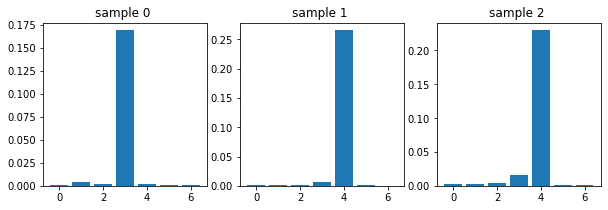

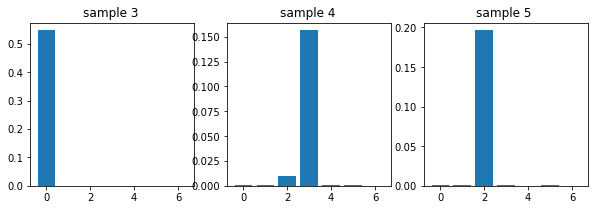

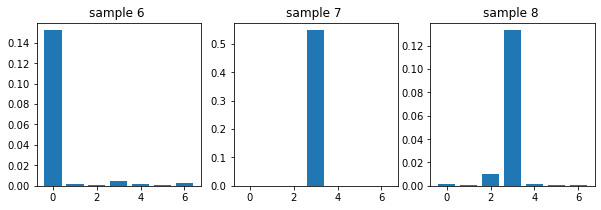

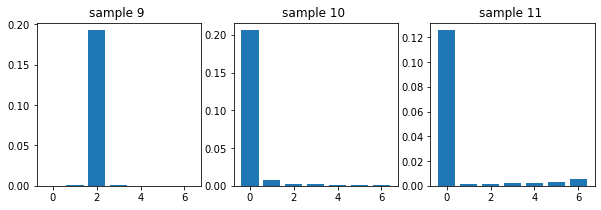

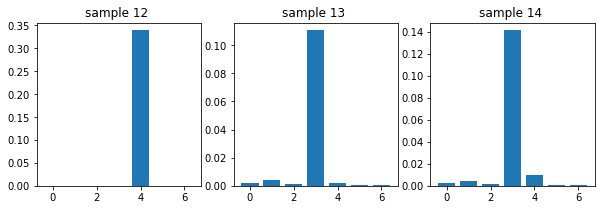

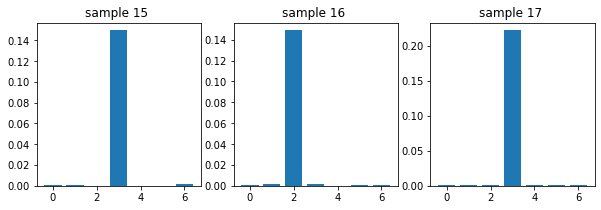

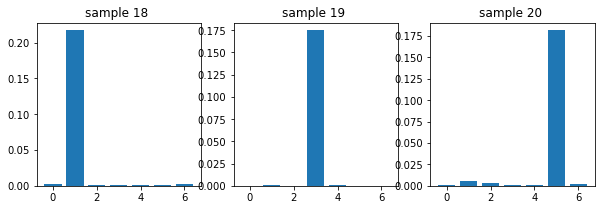

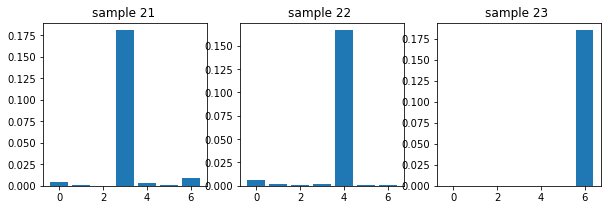

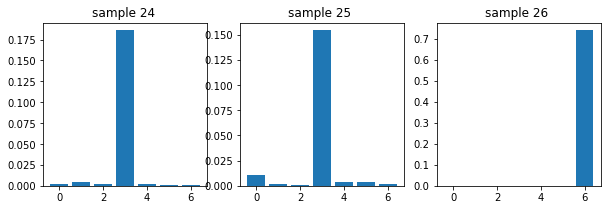

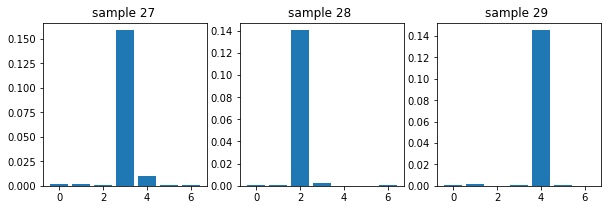

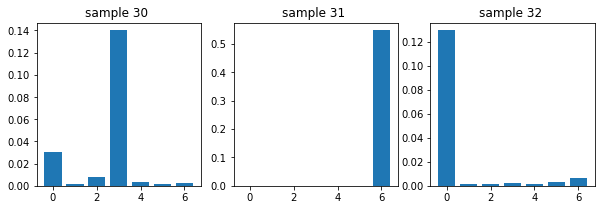

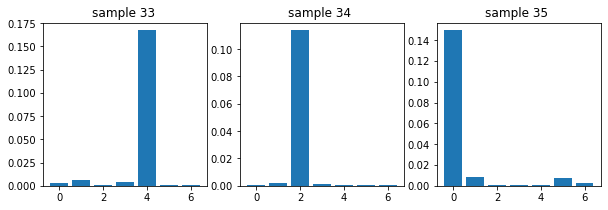

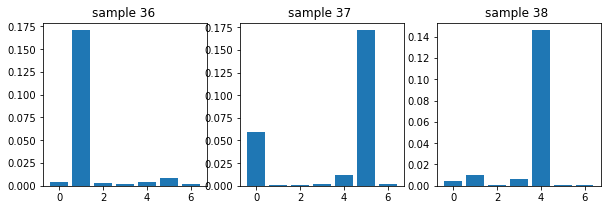

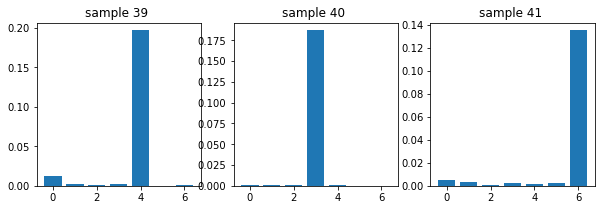

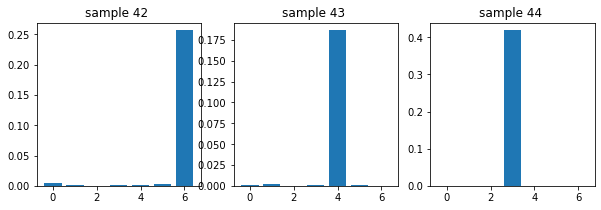

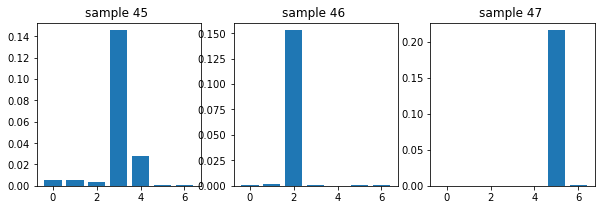

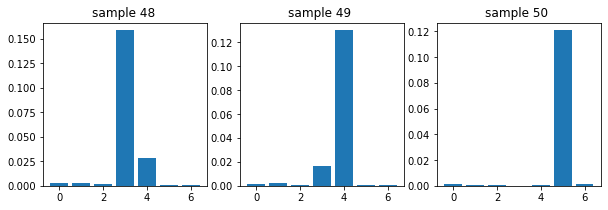

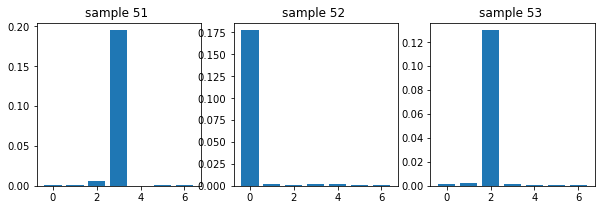

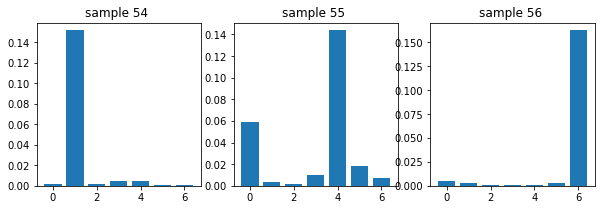

In [140]:
for i in range (1, 20):
    plt.figure(figsize = (10, 3))
    
    plt.subplot(1, 3, 1)
    plt.bar(range(7), pro_label[i*3-3])
    plt.title('sample %i ' % (i*3-3))
    
    plt.subplot(1, 3, 2)
    plt.bar(range(7), pro_label[i*3-2])
    plt.title('sample %i ' % (i*3-2))
    
    plt.subplot(1, 3, 3)
    plt.bar(range(7), pro_label[i*3-1])
    plt.title('sample %i ' % (i*3-1))
    
    plt.show()